This notebook shows an example of replicating the 'hello-world' cats vs dogs image classifer shown in lesson 1 of the fastai course. The data loading is slightly different but otherwise everything else is very similar. 

In [1]:
!pip install -U fastai --upgrade -q 

     |████████████████████████████████| 358kB 2.9MB/s 
     |████████████████████████████████| 10.5MB 12.9MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 1.1.1 which is incompatible.


In [2]:
from fastai.vision.all import *

## The data

In lesson 1 we saw a dog and cat classifier, since we probably won't often be classifying dogs vs cats in a GLAM setting we might want to test this approach with another dataset. To mimick the example notebooks, it is nice to have a relatively simple binary classification. 

Luckily the Internet Archive has a nice dataset which was created as part of an attempt to classify 'useful' vs 'not useful' book covers, to help IA decide whether to show a preview of the cover of a digitised book. Some more information on the original ask for help can be found in a [blog post](https://blog.archive.org/2019/01/05/helping-us-judge-a-book-by-its-cover-software-help-request/). 

The data can be downloaded through IA. The next few cells download and organise the data. We only use the 1923 data, since the other dataset is from a very different period. We could of course add this in later. 

In [3]:
!wget -q -O book-data.zip https://archive.org/compress/year-1923-not-very-useful-covers/formats=ZIP&file=/year-1923-not-very-useful-covers.zip

In [4]:
!mkdir 'book-data'

In [5]:
!unzip -q book-data.zip

In [6]:
!mv year-1923* book-data

In [7]:
!unzip -q book-data/year-1923-useful-covers.zip -d book-data/ 

Archive:  book-data/year-1923-useful-covers.zip
   creating: book-data/year-1923-useful-covers/
  inflating: book-data/year-1923-useful-covers/lehrbuchderexper02jose.jpg  
  inflating: book-data/year-1923-useful-covers/kingstoncitydi192223guil.jpg  
   creating: book-data/__MACOSX/
   creating: book-data/__MACOSX/year-1923-useful-covers/
  inflating: book-data/__MACOSX/year-1923-useful-covers/._kingstoncitydi192223guil.jpg  
  inflating: book-data/year-1923-useful-covers/twentysixthannua1923farm.jpg  
  inflating: book-data/year-1923-useful-covers/reliefsocietymag10reli.jpg  
  inflating: book-data/year-1923-useful-covers/dererumnaturprim00lucruoft.jpg  
  inflating: book-data/year-1923-useful-covers/biographyofsilve00setouoft.jpg  
  inflating: book-data/year-1923-useful-covers/outlineofworldto00johnuoft.jpg  
  inflating: book-data/__MACOSX/year-1923-useful-covers/._outlineofworldto00johnuoft.jpg  
  inflating: book-data/year-1923-useful-covers/goosestepstudyof00sinc.jpg  
  inflatin

In [8]:
!unzip -q book-data/year-1923-not-very-useful-covers.zip -d book-data/

Archive:  book-data/year-1923-not-very-useful-covers.zip
   creating: book-data/year-1923-not-very-useful-covers/
  inflating: book-data/year-1923-not-very-useful-covers/elizabethbarrett00inneuoft.jpg  
  inflating: book-data/year-1923-not-very-useful-covers/inaroundbookofda00boutuoft.jpg  
  inflating: book-data/year-1923-not-very-useful-covers/pleistoceneofnor00hayouoft.jpg  
  inflating: book-data/year-1923-not-very-useful-covers/lintroductiondel00brunuoft.jpg  
  inflating: book-data/year-1923-not-very-useful-covers/renaissanceinocad00symouoft.jpg  
  inflating: book-data/year-1923-not-very-useful-covers/hutchinsonssplen02philuoft.jpg  
  inflating: book-data/year-1923-not-very-useful-covers/olddutchpotteryt00neur.jpg  
  inflating: book-data/year-1923-not-very-useful-covers/anthropology00kroe.jpg  
  inflating: book-data/year-1923-not-very-useful-covers/generalcatalogue2325unse.jpg  
  inflating: book-data/year-1923-not-very-useful-covers/lightcolorinadve00luckrich.jpg  
  inflati

We can use `get_image_files` to quickly grab the image files from a folder. We can use `doc()` to get documentation for fastai functions. 

In [25]:
doc(get_image_files)

get_image_files(path, recurse=True, folders=None)
Get image files in `path` recursively, only in `folders`, if specified.

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [27]:
get_image_files('book-data/year-1923-not-very-useful-covers'), get_image_files('book-data/year-1923-useful-covers')

((#782) [Path('book-data/year-1923-not-very-useful-covers/unserefreilandna00silv.jpg'),Path('book-data/year-1923-not-very-useful-covers/luckybag1923unse.jpg'),Path('book-data/year-1923-not-very-useful-covers/oakserial1968loui.jpg'),Path('book-data/year-1923-not-very-useful-covers/nederlandsadelsb28unse_14.jpg'),Path('book-data/year-1923-not-very-useful-covers/crocesgoethe00crocuoft.jpg'),Path('book-data/year-1923-not-very-useful-covers/carlyletillmarri00wilsuoft.jpg'),Path('book-data/year-1923-not-very-useful-covers/motionpicturenew00moti_3.jpg'),Path('book-data/year-1923-not-very-useful-covers/theoryofbalanceo00suviuoft.jpg'),Path('book-data/year-1923-not-very-useful-covers/diseasesofcroppl00nowe.jpg'),Path('book-data/year-1923-not-very-useful-covers/gaietystagedoort00juppuoft.jpg')...],
 (#196) [Path('book-data/year-1923-useful-covers/fatherpriceofmar00byrn.jpg'),Path('book-data/year-1923-useful-covers/monographiedermi1923tube.jpg'),Path('book-data/year-1923-useful-covers/whoswhonewj

Helpfully, `get_image_files` also returns the number of items it finds (the first number in brackets). We can see that the labels are not balanced with more image examples for not useful (782) compared to useful (196). 

We can now load the data, since we don't have validation/train folders we have to pass in `valid_pct` to say how much data to hold out for validation. We should also `Resize(224)` 

In [10]:
dls = ImageDataLoaders.from_folder('book-data/', valid_pct=0.3, item_tfms=Resize(224))

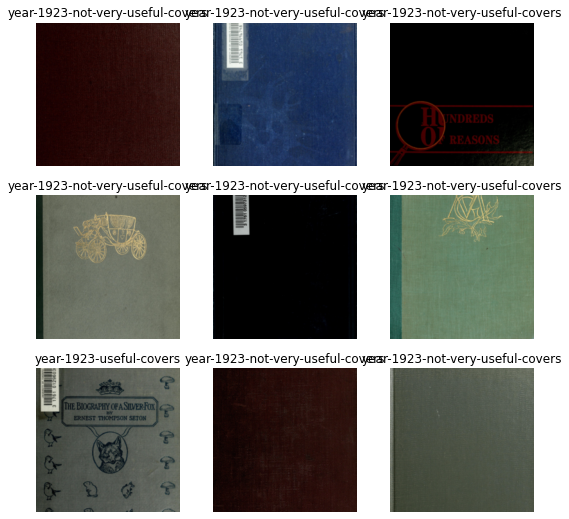

In [11]:
dls.show_batch()

In [16]:
learn = cnn_learner(dls, resnet18, metrics=[accuracy, F1Score(average='macro')])

In [17]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.121532,1.060244,0.679181,0.648160,01:56


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.716467,0.830403,0.754266,0.716452,01:53
1,0.629168,0.702497,0.819113,0.776449,01:55
2,0.555028,0.751190,0.846416,0.800978,01:55
3,0.461929,0.723831,0.846416,0.795686,01:56
4,0.395376,0.513547,0.897611,0.851721,01:55
5,0.332068,0.525441,0.904437,0.858454,01:55
6,0.290341,0.490802,0.914676,0.874342,01:55
7,0.256017,0.470589,0.921502,0.881666,01:55
8,0.227593,0.445409,0.921502,0.881666,01:55
9,0.202307,0.432368,0.924915,0.886129,01:57


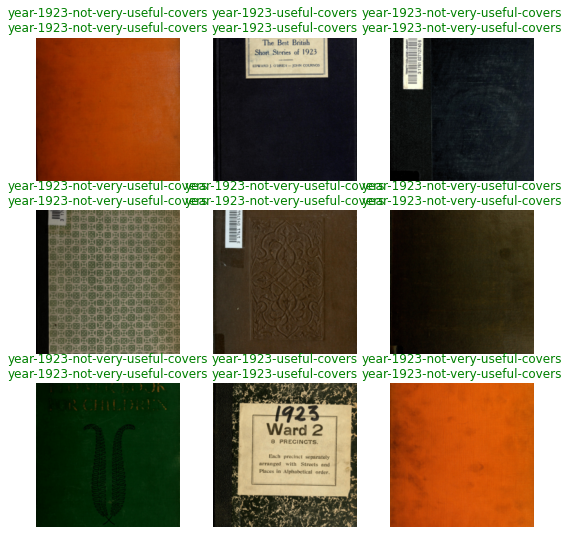

In [18]:
learn.show_results()

### Looking at the results 

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

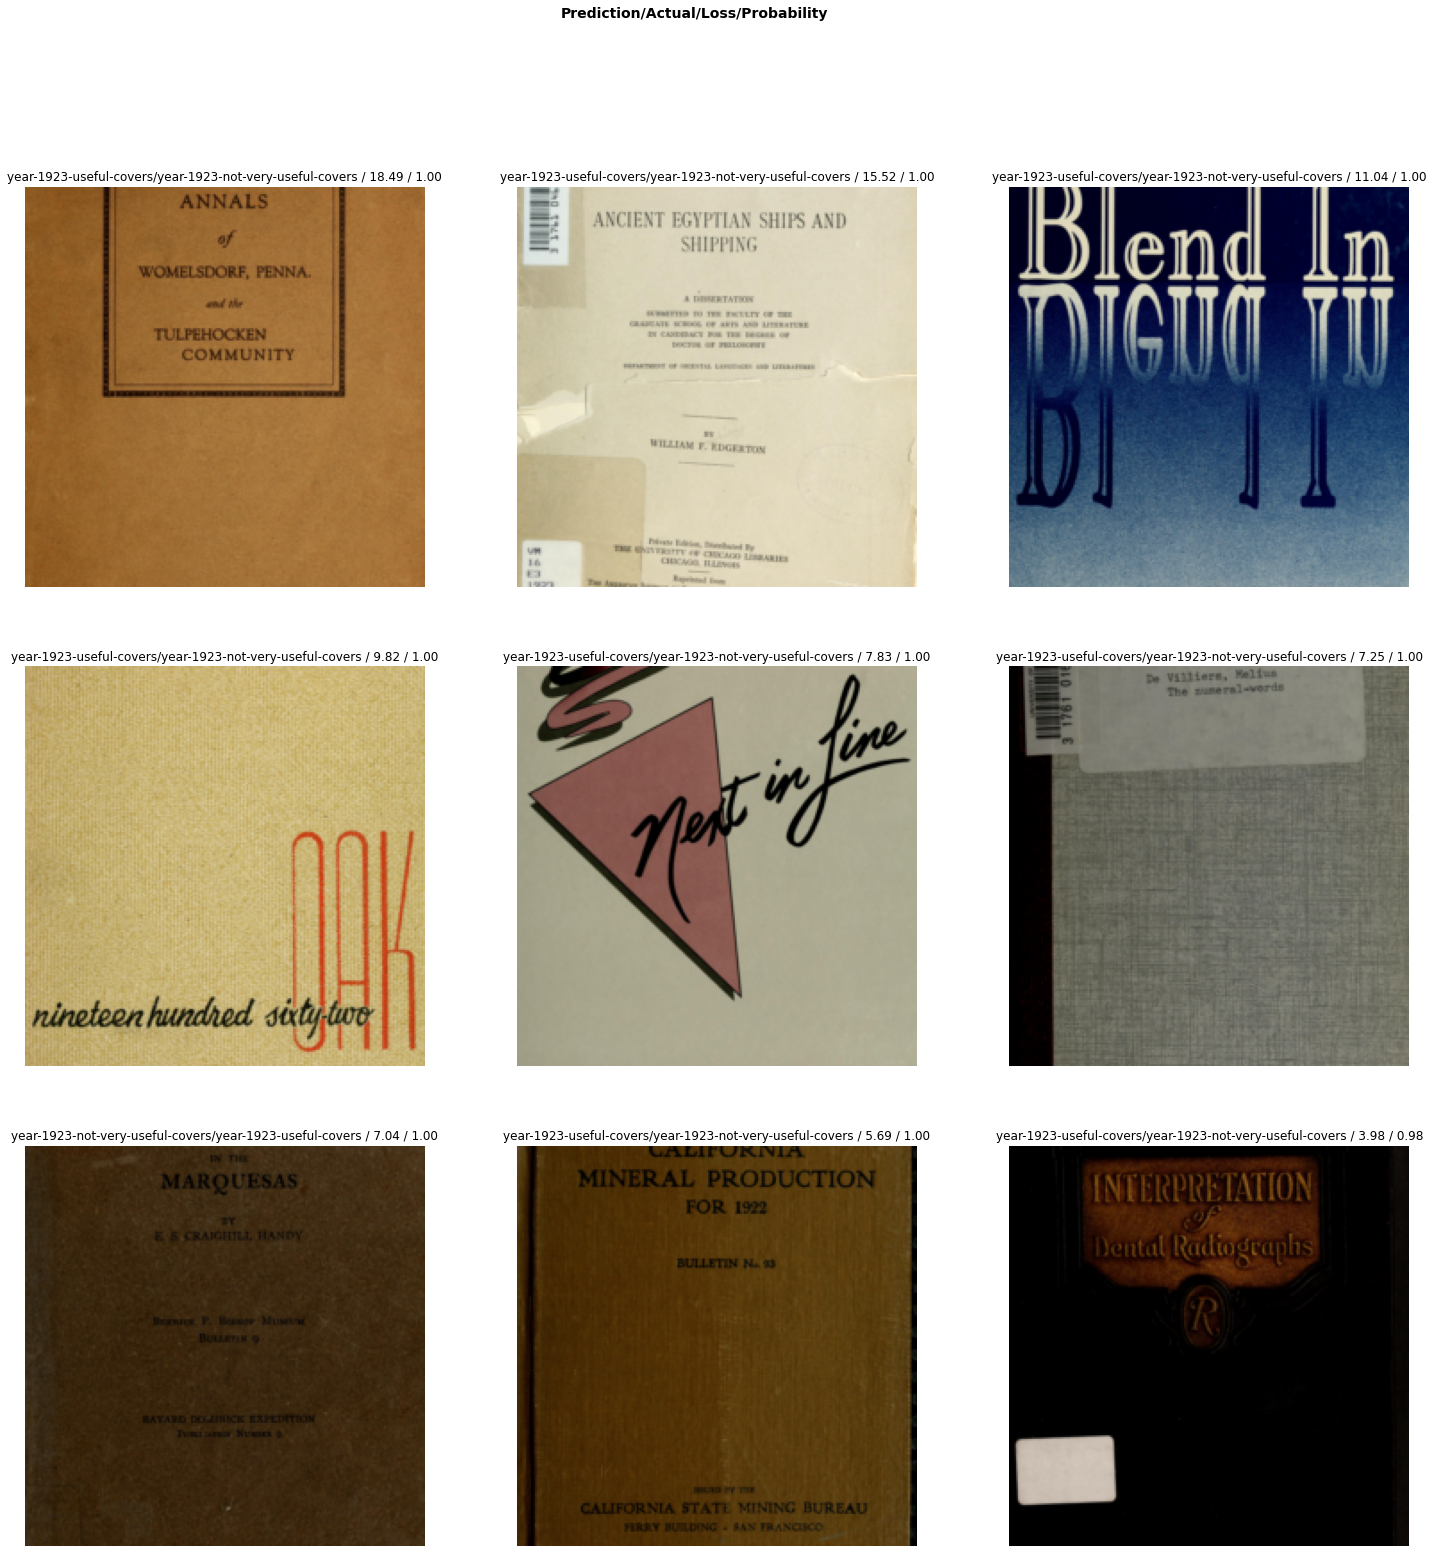

In [24]:
interp.plot_top_losses(9,figsize=(25,25))

In my opinion some of the training labels aren't correct. For example, sometimes books with some text are lablled as useful, others as not-useful. This is probably partly due to the labels being slightly subjective. 

*fin*